# Bowers method with well log

Pore pressure prediction with Bowers' method using well log data.

Predicton of geopressure using Bowers' model needs the following steps:

1. determine Bowers loading equation coefficients A and B

2. determine Bowers unloading equation coefficients $V_{max}$ and U

3. Pressure Prediction

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
from __future__ import print_function, division, unicode_literals
# for python 2 and 3 compatibility
from builtins import str
try:
    from pathlib import Path
except:
    from pathlib2 import Path

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

import numpy as np
from IPython.display import display
#--------------------------------------------
import sys
ppath = "../.."

if ppath not in sys.path:
    sys.path.append(ppath)
#--------------------------------------------
import pygeopressure as ppp

## 1. determine Bowers loading equation coefficients A and B

Create survey with the example survey `CUG`:

In [2]:
# set to the directory on your computer
SURVEY_FOLDER = "C:/Users/yuhao/Desktop/CUG_depth"

survey = ppp.Survey(Path(SURVEY_FOLDER))

Retrieve well `CUG1`:

In [3]:
well_cug1 = survey.wells['CUG1']

Get velocity log:

In [4]:
vel_log = well_cug1.get_log("Velocity")

Preprocessing velocity data

In [5]:
vel_log_filter = ppp.upscale_log(vel_log, freq=20)

vel_log_filter_smooth = ppp.smooth_log(vel_log_filter, window=1501)

View velocity and processed velocity

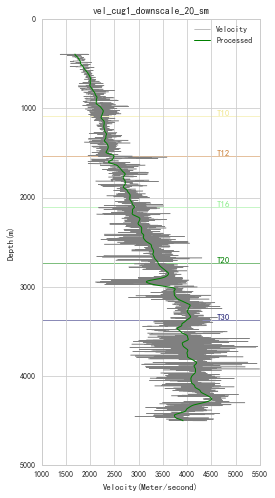

In [6]:
fig_vel, ax_vel = plt.subplots()
ax_vel.invert_yaxis()
# plot velocity
vel_log.plot(ax_vel, label='Velocity')
# plot horizon
well_cug1.plot_horizons(ax_vel)
# plot processed velocity
vel_log_filter_smooth.plot(ax_vel, color='g', zorder=2, label='Processed', linewidth=1)

# set fig style
ax_vel.set(ylim=(5000,0), aspect=(4600/5000)*2)
ax_vel.legend()
fig_vel.set_figheight(8)

Optimize for Bowers' loading equation coefficients A, B:

In [7]:
a, b, err = ppp.optimize_bowers_virgin(
    well=well_cug1, 
    vel_log=vel_log_filter_smooth, 
    obp_log='Overburden_Pressure', 
    upper='T12', 
    lower='T20',
    pres_log='loading', 
    mode='both')

Plot optimized virgin curve:

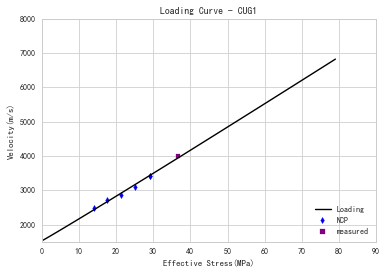

In [8]:
fig_bowers, ax_bowers = plt.subplots()

ppp.plot_bowers_vrigin(
    ax=ax_bowers,
    well=well_cug1, 
    a=a,
    b=b,
    vel_log=vel_log_filter_smooth, 
    obp_log='Overburden_Pressure', 
    upper='T12', 
    lower='T20',
    pres_log='loading', 
    mode='both')

## 2. determine Bowers unloading equation coefficients  $V_{max}$  and U

After manually select paramter U, optimze for parameter U:

In [9]:
u = ppp.optimize_bowers_unloading(
    well=well_cug1,
    vel_log=vel_log_filter_smooth, 
    obp_log='Overburden_Pressure', 
    a=a,
    b=b,
    vmax=4600, 
    pres_log='unloading')

Draw unloading curve and virgin curve together with optimized parameters:

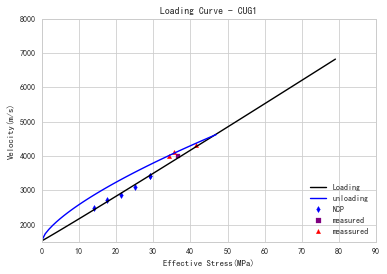

In [10]:
fig_bowers, ax_bowers = plt.subplots()
# draw virgin(loading) curve
ppp.plot_bowers_vrigin(
    ax=ax_bowers,
    well=well_cug1, 
    a=a,
    b=b,
    vel_log=vel_log_filter_smooth, 
    obp_log='Overburden_Pressure', 
    upper='T12', 
    lower='T20',
    pres_log='loading', 
    mode='both')

# draw unloading curve
ppp.plot_bowers_unloading(
    ax=ax_bowers,
    a=a,
    b=b,
    vmax=4600,
    u=u,
    well=well_cug1,         
    vel_log=vel_log_filter_smooth, 
    obp_log='Overburden_Pressure', 
    pres_log='unloading')

## 3. Pressure Prediction with Bowers model

predict pressure with coefficients calculated above:

In [11]:
pres_log = well_cug1.bowers(
    vel_log=vel_log_filter_smooth, a=a, b=b, u=u)

View Bowers Pressure Results:

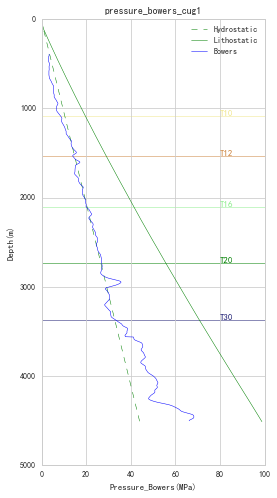

In [15]:
fig_pres, ax_pres = plt.subplots()
ax_pres.invert_yaxis()
# plot hydrostatic
well_cug1.hydro_log().plot(ax_pres, linestyle='--', color='green', label='Hydrostatic')
# plot OBP
well_cug1.get_log("Overburden_Pressure").plot(ax_pres, color='green', label='Lithostatic')
# plot pressure
pres_log.plot(ax_pres, label='Bowers', color='blue')
# plot horizon
well_cug1.plot_horizons(ax_pres)


# set fig style
ax_pres.set(ylim=(5000,0), aspect=(100/5000)*2)
ax_pres.legend()
fig_pres.set_figheight(8)